In [2]:
#from alisa.clustering import NearestNeighbors
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import itertools
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.interpolate import interp1d

from scipy.stats import spearmanr,pearsonr
from sklearn.manifold import MDS

def hist(vals,bins,linestyle='-',label='',color=None):
    a,b= np.histogram(vals,bins)
    bin_centers = 0.5*(b[1:]+b[:-1])
    plt.plot(bin_centers,a/np.sum(a),linestyle=linestyle,label=label,color=color)

In [53]:
global_matrix_=pd.read_csv('results/dist_matrix_global.csv.gz')
global_matrix=global_matrix_.values

samples=global_matrix_.columns.values
patients=[s.split('_')[0] for s in samples]
cell_types=[s.split('_')[1] for s in samples]
patients_to_num=dict(zip(np.unique(patients),np.arange(9)))

files=!ls local
local_matrix=pd.read_csv('results/dist_matrix_local.csv')
local_matrix.columns=['sample1','sample2','d1']
order=['gen','++','CD8+','Tconv','Treg']
names=[r'$P_{\rm gen}$','DP','CD8+','Tconv','Treg']
colors=['black','darkorange','gold','darkgreen','darkblue']

In [54]:
len_datasets=len(samples)
local_matrix1=np.zeros((len_datasets,len_datasets))
individual_matrix=np.zeros((len_datasets,len_datasets))
samples_in_matrix=local_matrix[['sample1','sample2']].values.astype(np.str)
for i in range(len_datasets):
    for j in range(len_datasets):
        sel=[ (samples[i] in s[0] and samples[j] in s[1]) or (samples[i] in s[1] and samples[j] in s[0]) for s in samples_in_matrix]
        vals=local_matrix[sel].values[0,2]
        local_matrix1[i,j]=vals
        local_matrix1[j,i]=vals
        if samples[i].split('_')[0]==samples[j].split('_')[0]:
            individual_matrix[i,j]=patients_to_num[samples[i].split('_')[0]]
            individual_matrix[j,i]=patients_to_num[samples[i].split('_')[0]]
local_matrix1=np.nan_to_num(local_matrix1)

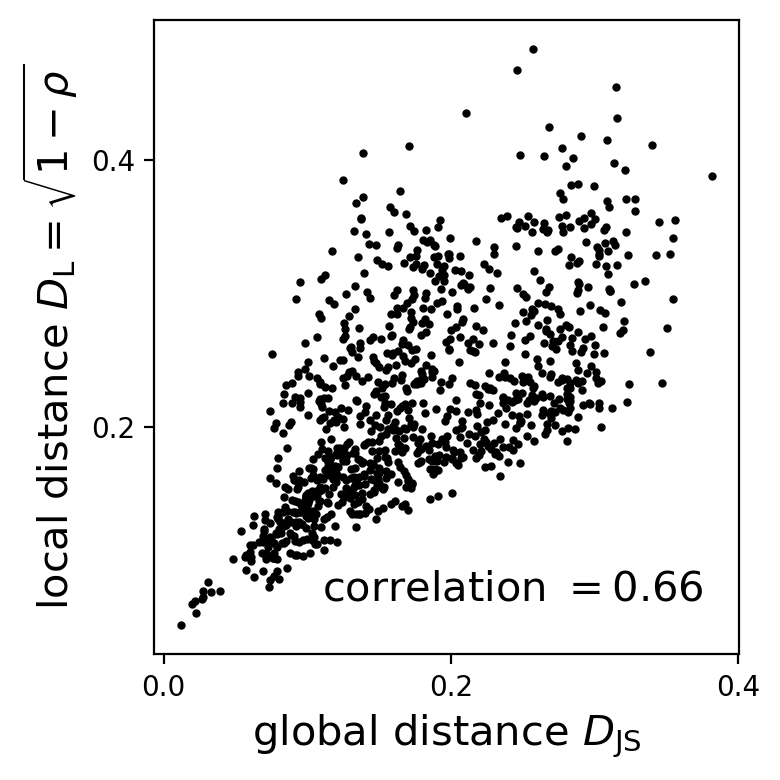

In [60]:
#f, ax = plt.subplots(figsize=(6, 6))
size=local_matrix1.shape[0]
x=global_matrix[np.triu_indices(size,k=1)]
y=local_matrix1[np.triu_indices(size,k=1)]
plt.figure(figsize=(4,4),dpi=200)
plt.locator_params(nbins=4)

corr=spearmanr(x,y)[0]
h=plt.scatter(x=x, y=y,color='k',rasterized=True,s=4)
plt.text(0.11, 0.07, r'correlation $={0:.2f}$'.format(corr),fontsize=15)
plt.xlabel(r'global distance $D_{\rm JS}$',fontsize=15)
plt.ylabel(r'local distance $D_{\rm L}=\sqrt{1-\rho}$',fontsize=15)
plt.tight_layout()
plt.show()

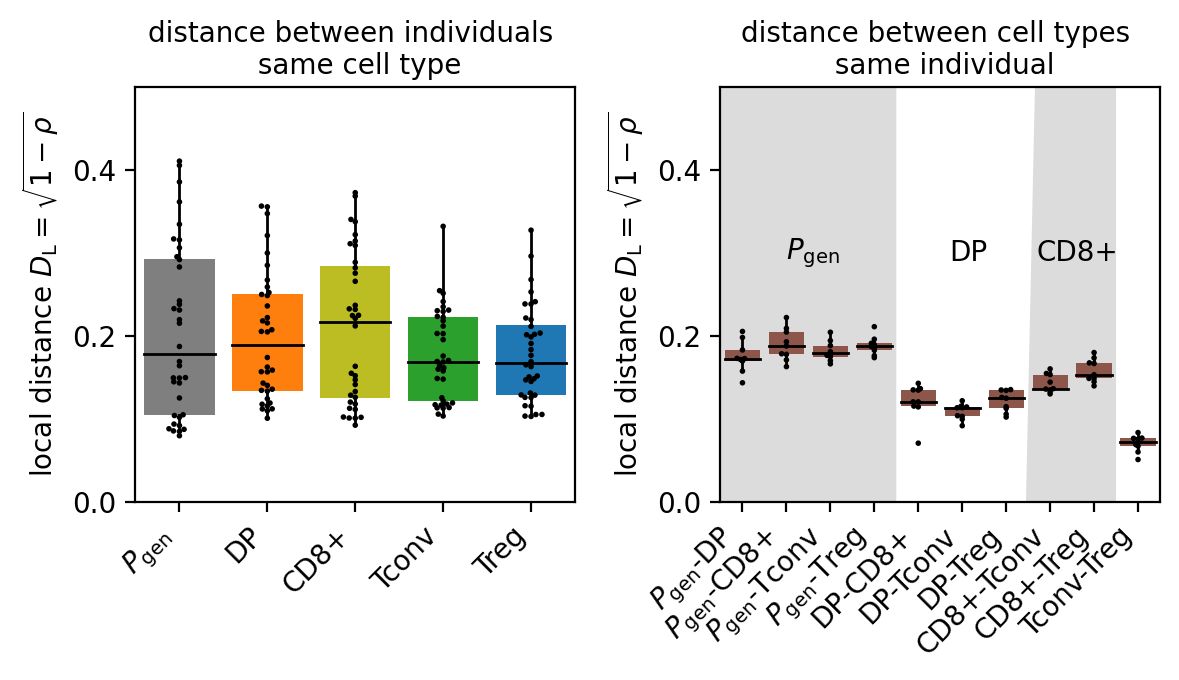

In [57]:
fig, ax = plt.subplots(figsize=(6,3.5),dpi=200)
order=['gen','++','CD8+','Tconv','Treg']
names=[r'$P_{\rm gen}$','DP','CD8+','Tconv','Treg']
colors=['grey','darkorange','gold','darkgreen','lightblue']
palette=sns.color_palette()
colors=[palette[i] for i in [7,1,8,2,0]]
names_dict={'++':'DP', 'CD8+':'CD8+', 'Tconv':'Tconv', 'Treg':'Treg', 'gen':r'$P_{\rm gen}$'}

xmin=0.
xmax=.5
dist_matrix=local_matrix1

# here we focus on different parts of the distance matrix
inter_individuals=[]
intra_individuals=[]
values_intra=[]
values=[]
for j,cell in enumerate(order):
    d=dist_matrix[np.array(cell_types)==cell][:,np.array(cell_types)==cell] # select ony intra cell-type
    inter_individuals.append(d[np.triu_indices(9,k=1)]) # off diagonal elements for inter-individuals 9*8/2 = 36 elements
    values.append([names_dict[cell]]*len(d[np.triu_indices(9,k=1)])) # label 

# build df for seaborn plotting
i=np.concatenate(inter_individuals)
j=np.concatenate(values)
data=pd.DataFrame(zip(i,j),columns=['DJS','cell_type'])

# plot
ax=plt.subplot(121)
alpha=1
plt.locator_params(nbins=4)
c=colors
sns.boxplot(x="cell_type", y="DJS", data=data,order=names,palette=colors,linewidth=1,fliersize=0,width=0.8,saturation=1,boxprops={"linewidth": 0})
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, alpha))
for i,box in enumerate(ax.artists):
        # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
        ax.lines[j].set_color('black')
        if j%6==2 or j%6==3:ax.lines[j].set_color('white')

sns.swarmplot(x="cell_type", y="DJS", data=data,order=names,color='k',size=1,edgecolor='k',linewidth=1.,orient='v')
plt.xticks(np.arange(len(names)),names)
plt.tight_layout()
plt.ylabel('')
plt.xlabel('')
plt.ylim([xmin,xmax])
plt.ylabel(r'local distance $D_{\rm L}=\sqrt{1-\rho}$',fontsize=10)
plt.xticks(rotation=90)
plt.title('distance between individuals \n same cell type',fontsize=10,rotation_mode="anchor")


# focus on all pairs of cell types
pairs=list(itertools.combinations(np.arange(len(order)),2))
individual_diagonal=[]
values=[]
for j,(cell1,cell2) in enumerate(pairs):
    d=dist_matrix[np.array(cell_types)==order[cell1]][:,np.array(cell_types)==order[cell2]] # select pairs of cells
    d1=individual_matrix[np.array(cell_types)==order[cell1]][:,np.array(cell_types)==order[cell2]] # select pairs of cells
    intra_individuals.append(np.diagonal(d)) # elements on the diagonal are from the same individual
    values.append([names_dict[order[cell1]]+'-'+ names_dict[order[cell2]]]*9)


# build df for plotting
i=np.concatenate(intra_individuals)
j=np.concatenate(values)
data=pd.DataFrame(zip(i,j),columns=['DJS','cell_type'])
plt.xticks(rotation=45,ha="right",fontsize=10)

plt.yticks(fontsize=10)

# plot 
ax=plt.subplot(122)
plt.locator_params(nbins=4)
colors=['black','darkorange','gold','darkgreen','darkblue']
selection_of_pairs=['$P_{\\rm gen}$-DP', '$P_{\\rm gen}$-CD8+', '$P_{\\rm gen}$-Tconv',
       '$P_{\\rm gen}$-Treg','DP-CD8+',
       'DP-Tconv', 'DP-Treg', 'CD8+-Tconv', 'CD8+-Treg', 'Tconv-Treg']
plt.locator_params(nbins=4)
sns.boxplot(x="cell_type", y="DJS", data=data,color=palette[5],linewidth=1,fliersize=0,width=0.8,saturation=1,boxprops={"linewidth": 0})
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, alpha))
sns.swarmplot(x="cell_type", y="DJS", data=data,color='k',size=1,edgecolor='k',linewidth=1.,orient='v')
for i,box in enumerate(ax.artists):
        # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
        ax.lines[j].set_color('black')
        if j%6==2 or j%6==3:ax.lines[j].set_alpha(0)
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel(r'local distance $D_{\rm L}=\sqrt{1-\rho}$',fontsize=10)
plt.xlabel('')
plt.xticks(rotation=45,ha="right")

plt.ylim([xmin,xmax])
plt.title('distance between cell types \n same individual',fontsize=10,rotation_mode="anchor")
plt.tight_layout()
plt.fill_between([-1,3.5],[0,5],facecolor='gainsboro', alpha=1,zorder=-1,linewidth=0)
plt.fill_between([6.45,8.5],[0,5],facecolor='gainsboro', alpha=1,zorder=-1,linewidth=0)
plt.text(1.,0.3,r'$P_{\rm gen}$',verticalalignment='center')
plt.text(4.7,0.3,r'DP',verticalalignment='center')
plt.text(6.7,0.3,r'CD8+',verticalalignment='center')
plt.show()